In [1]:
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from libs.image_utils import (get_random_patch_list,
                              draw_bounding_box,
                              calc_iou_accuracy,
                              calc_iou_top_1_accuracy)

from models.tf_template import BaseTfClassifier
from models.custom.detector import Detector

from libs.dataset_utils import prepare_data_from_tfrecord
from configs.project_config import project_path
from helpers import (load_data_with_meta,
                     load_meta,
                     evaluate,
                     visualize,
                     visualize_cam,
                     restore_preprocessed)

In [2]:
"""
Constant
"""
NUM_CLASS = 200
INPUT_SHAPE = (64, 64, 3)
MODEL_BASE_INPUT_SHAPE = (224, 224, 3)

tfrecord_train_dir = "{}/data/tiny_imagenet_200/tfrecord/train".format(project_path)
tfrecord_valid_dir = "{}/data/tiny_imagenet_200/tfrecord/valid".format(project_path)
tfrecord_test_dir = "{}/data/tiny_imagenet_200/tfrecord/test".format(project_path)

has_pretrained_path = "{}/checkpoints/pretrained/has_inception_v3/has_inception_v3".format(project_path)

pickle_data_full_path = "{}/data/tiny_imagenet_200/pickle/tiny_imagenet.pickle".format(project_path)

# Load Model

In [3]:
model = BaseTfClassifier().load(has_pretrained_path, flag_import_graph=True, model=Detector)

INFO:tensorflow:Restoring parameters from /home/sungju/projects/sj/weakly_detector/checkpoints/pretrained/has_inception_v3/has_inception_v3


In [4]:
# ==============================================================================
# 이 dataset API로만 HaS 인풋을 받을 수 있습니다.
with model.g.as_default():
    """
    Read Data
    """
    d = prepare_data_from_tfrecord(
        tfrecord_train_dir=tfrecord_train_dir,
        tfrecord_valid_dir=tfrecord_valid_dir,
        tfrecord_test_dir=tfrecord_test_dir,
        batch_size=200,
        shuffle_buffer_size=1000)
    (X, Y,
     init_dataset_train,
     init_dataset_train_has,
     init_dataset_valid) = (d['X'], d['Y'],
                            d['init_dataset_train'],
                            d['init_dataset_train_has'],
                            d['init_dataset_valid'])

In [5]:
"""
Read Data Pickle
"""
try :
    d = load_data_with_meta(pickle_data_full_path)
    (X_train, P_train, Y_train, Y_train_one_hot) = (d['X_train'], d['P_train'], d['Y_train'] ,d['Y_train_one_hot'])
    (X_valid, P_valid, Y_valid, Y_valid_one_hot) = (d['X_valid'], d['P_valid'], d['Y_valid'] ,d['Y_valid_one_hot'])
    (X_test, P_test, Y_test, Y_test_one_hot) = (d['X_test'], d['P_test'], d['Y_test'] ,d['Y_test_one_hot'])
    (idx_word_dict, word_idx_dict) = (d['idx_word_dict'], d['word_idx_dict'])
    (idx_nid_dict, nid_idx_dict) = (d['idx_nid_dict'], d['nid_idx_dict'])
except Exception as e: 
    print("maybe there is no pickle data: {}".format(e))

# HaS input Test

In [ ]:
# ==============================================================================
# Data From Tfrecord
model.sess.run(init_dataset_train_has)
X_sample, Y_sample_one_hot = model.sess.run([X, Y])
X_sample = restore_preprocessed(X_sample)
Y_sample = np.argmax(Y_sample_one_hot, axis=1)

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(12,12))
for y in range(3):
    for x in range(3):
        sample = X_sample[x+(y%3)*3]
        axs[y][x].imshow(sample)

# Test Sample Data

In [ ]:
# ==============================================================================
# Data From Pickle File
num_sample = 100
X_sample =  X_train[:num_sample]
P_sample = P_train[:num_sample]
Y_sample_one_hot = Y_train_one_hot[:num_sample]
Y_sample = Y_train[:num_sample]

In [ ]:
(cam_list_sample,
bbox_list_sample,
gt_known_loc_accuracy_sample,
top_1_loc_accuracy_sample) = evaluate(model, X_sample, P_sample, Y_sample_one_hot, 'sample')

In [ ]:
visualize_cam(X_rmded.astype(np.uint8), Y_sample, cam_list_sample, idx_word_dict, n_show=2, start=0)

In [ ]:
(cam_list_sample,
bbox_list_sample,
gt_known_loc_accuracy_sample,
top_1_loc_accuracy_sample) = evaluate(model, X_sample, P_sample, Y_sample_one_hot, 'sample')

In [ ]:
visualize_cam(X_rmded.astype(np.uint8), Y_sample, cam_list_sample, idx_word_dict, n_show=2, start=0)

# Evaluation

In [6]:
(cam_list_train,
bbox_list_train,
gt_known_loc_accuracy_train,
top_1_loc_accuracy_train) = evaluate(model, X_train, P_train, Y_train_one_hot, 'train')

GT-known-Loc train iou_accuracy : 0.4363375
Top-1 Loc train iou_accuracy : 0.2482


In [7]:
(cam_list_valid,
bbox_list_valid,
gt_known_loc_accuracy_valid,
top_1_loc_accuracy_valid) = evaluate(model, X_valid, P_valid, Y_valid_one_hot, 'valid')

GT-known-Loc valid iou_accuracy : 0.43405
Top-1 Loc valid iou_accuracy : 0.24325


In [8]:
(cam_list_test,
bbox_list_test,
gt_known_loc_accuracy_test,
top_1_loc_accuracy_test) = evaluate(model, X_test, P_test, Y_test_one_hot, 'test')

GT-known-Loc test iou_accuracy : 0.4322
Top-1 Loc test iou_accuracy : 0.2393


# Visualization

(<matplotlib.figure.Figure at 0x7f9e0b3d4d30>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e0b3dd0b8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e0b231278>]], dtype=object))

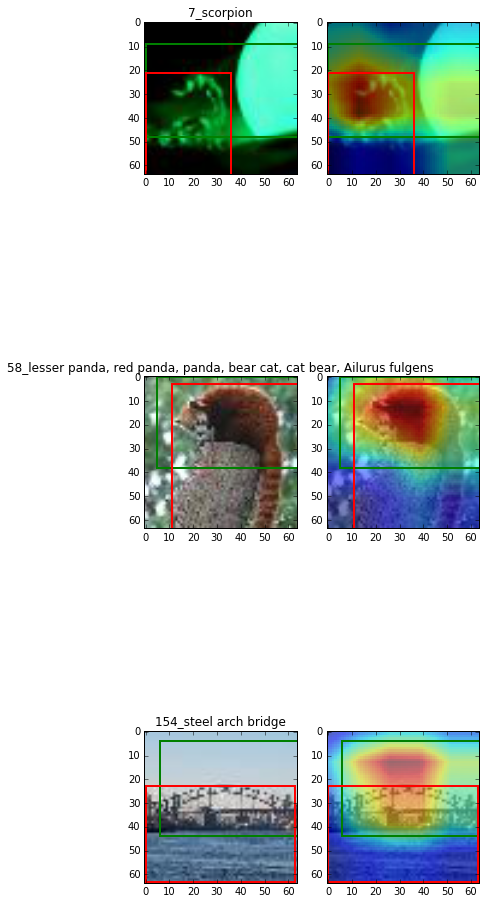

In [9]:
visualize(X_train, P_train, Y_train, cam_list_train, bbox_list_train, idx_word_dict,
          n_show=3, start=0)

(<matplotlib.figure.Figure at 0x7f9e0b253d30>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e0b025278>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f9d846889e8>]], dtype=object))

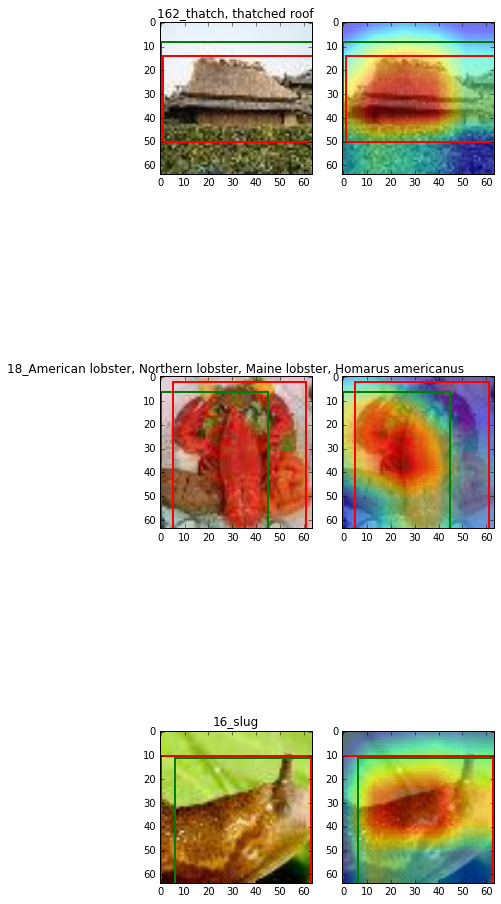

In [10]:
visualize(X_valid, P_valid, Y_valid, cam_list_valid, bbox_list_valid, idx_word_dict,
          n_show=3, start=0)

(<matplotlib.figure.Figure at 0x7f9d846f2400>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d845233c8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f9d8434b198>]], dtype=object))

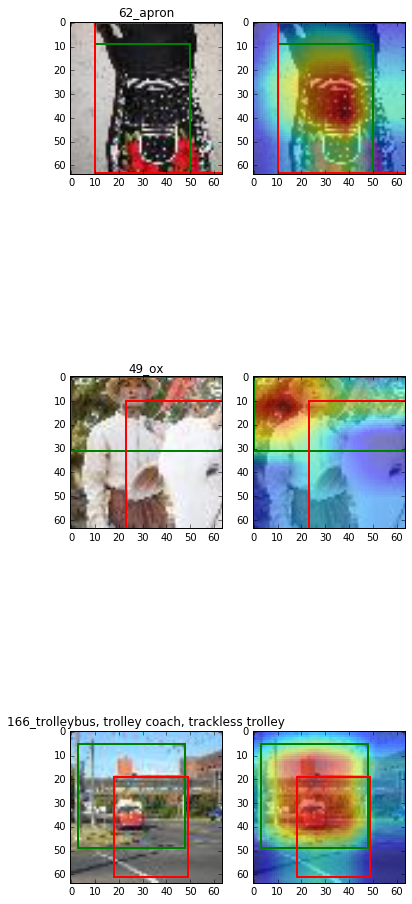

In [11]:
visualize(X_test, P_test, Y_test, cam_list_test, bbox_list_test, idx_word_dict,
          n_show=3, start=0)

- - -

# Accuracy

In [ ]:
result = model.evaluate(X_train, Y_train_one_hot, batch_size=128)
print("train accuracy :{}". format(result[1]))
result = model.evaluate(X_valid, Y_valid_one_hot, batch_size=128)
print("valid accuracy :{}". format(result[1]))
result = model.evaluate(X_test, Y_test_one_hot, batch_size=128)
print("test accuracy :{}". format(result[1]))